## DBSCAN Clustering Fitting Paramaters

## Summary
- Select three health indicators from DHIS2:
    - Maternal Health: Institutional Normal Delivery Rate (Only EmOC Facilities)
    - Maternal Health: Maternal Case fatality rate (EmOC)
    - Maternal Health: Percentage of cases with puerperal sepsis among admitted patient in EmONC
    - Maternal Health: Percentage of postpartum hemorrhage among admitted patient in EmONC
- Period 2013 - 2018
- Geogrpahic levels: Districts

## Packages

```
!pip install --upgrade pip
!pip install fuzzywuzzy
```

In [431]:
import os
import glob
import operator
import itertools
from fuzzywuzzy import fuzz
from collections import Counter
import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import seaborn as sns
from matplotlib import pyplot as plt

import shapefile as shp

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from matplotlib.collections import PatchCollection

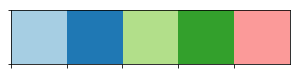

In [432]:
sns.palplot(sns.color_palette('Paired', 5))

In [433]:
WD = '/Users/edinhamzic/Symphony/wb_bangladesh/'
DATA = 'output/dhis2/health_indicators/'
SHAPE_PATH = 'data/shapefiles/gadm36_BGD_shp/gadm36_BGD_2'
GEO_LEVEL = 'districts'
os.chdir(WD)

## Custome functions

In [434]:
def read_data(dir_path, pattern):
    files_list = glob.glob(os.path.join(dir_path, pattern))
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file)
    return data_dict

def subset_data(data_dict, var_list):
    output = dict()
    for key, value in data_dict.items():
        output[key] = data_dict[key][var_list]
    return output

def get_shape(data_dict):
    output_list = []
    for key, item in data_dict.items():
        
        output_list.append(item.shape)
    return output_list

def evaluate_dbscan(input_df, density, min_sample, prune=True, ideal = (3.1,8)):
    samples = list(itertools.product(density, min_sample))
    counter = 0
    models = pd.DataFrame(columns=['EPS',
                                   'min_samples',
                                   'num_clusters_with_unasign',
                                   'num_unassigned_districts',
                                   'per_unassigned_districts',
                                   'per_of_maxclass',],index=range(len(samples)))
    df = input_df.copy(deep=True)
    for iteration in samples:
        model = DBSCAN(eps=iteration[0], min_samples=iteration[1], metric='euclidean',algorithm='auto').fit(df)
        models.loc[counter,'EPS'] = iteration[0]
        models.loc[counter, 'min_samples'] = iteration[1]
        models.loc[counter, 'num_clusters_with_unasign'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'per_unassigned_districts'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'per_unassigned_districts'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'per_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'per_of_maxclass'] = 100
        models.loc[counter, 'num_unassigned_districts'] = Counter(model.labels_)[-1]
        df['class'] = pd.Categorical(model.labels_)
        counter += 1
        if (iteration[0], iteration[1]) == ideal:
            output_model = DBSCAN(eps=iteration[0], min_samples=iteration[1], metric='euclidean',algorithm='auto').fit(df)
    if prune:
        models = models[models['num_unassigned_districts'] < (models.shape[0]/2)]
        models = models[models['num_clusters_with_unasign'] > 3]
        models = models.sort_values(by='num_unassigned_districts')
    else:
        pass
    return models, output_model

def subset_dict(data_dict, subset_vars, geo_type):
    out = list()
    for key, value in data_dict.items():
        geo = key.split("/")[3].split("_")[0]
        if geo == geo_type:
            tmp = data_dict[key][subset_vars]
            tmp['year'] = key.split("_")[2]
            out.append(tmp)
    return pd.concat(out, axis=0)


def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m

def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = str(data.loc[data[data_key] == int(district[mapobj_key]),'colors'][0])
    return mapobj
    
def plot_geos(mapobj, mapobj_key, labels_colors, title):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(title + ".jpeg")
    plt.show()
    plt.close()

def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))

## Getting data

In [435]:
names_matching = {
    "01MaternalHealth: llFRYYZLkur": "01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)",
    "01MaternalHealth: IVpv2Tj5rbj": "01MaternalHealth: Maternal Case fatality rate (EmOC)", 
    "01MaternalHealth: UeBuoOKVSt9": "01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC",
    "01MaternalHealth: DA4SHBTcotS": "01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC",}

In [436]:
var_id = ["True"]
variables = ["01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)",
             "01MaternalHealth: Maternal Case fatality rate (EmOC)", 
             "01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC",
             "01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC",]
variables = ["01MaternalHealth: llFRYYZLkur",
             "01MaternalHealth: IVpv2Tj5rbj", 
             "01MaternalHealth: UeBuoOKVSt9",
             "01MaternalHealth: DA4SHBTcotS",]
subset_list = var_id + variables 
var_id + variables 

['True',
 '01MaternalHealth: llFRYYZLkur',
 '01MaternalHealth: IVpv2Tj5rbj',
 '01MaternalHealth: UeBuoOKVSt9',
 '01MaternalHealth: DA4SHBTcotS']

In [437]:
data_code = read_data(dir_path=DATA, pattern='*_CODE.csv')
data_name = read_data(dir_path=DATA, pattern='*_NAME.csv')
data = subset_data(data_dict=data_code, var_list=subset_list)

In [438]:
[district for district in data_code['output/dhis2/health_indicators/District_2018_CODE.csv'].columns if '01MaternalHealth' in district]
[district for district in data_name['output/dhis2/health_indicators/District_2018_NAME.csv'].columns if '01MaternalHealth' in district]

['01MaternalHealth: % of maternal death reported individually with causes of death',
 '01MaternalHealth: Institutional C-section rate',
 '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)',
 '01MaternalHealth: Maternal Case fatality rate (EmOC)',
 '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC',
 '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC',
 '01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC',
 '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC',
 '01MaternalHealth: Total Complicated Mother',
 '01MaternalHealth: Total No. of pregnant mothers with obstetric complication',
 '01MaternalHealth: Total birth in EmONC facilities',
 '01MaternalHealth: Total deliveries in EmONC facilities',
 '01MaternalHealth: Total still birth at EmOC facility']

In [439]:
maternal_data = subset_dict(data_dict=data, subset_vars=subset_list, geo_type='District')
maternal_data.columns

Index(['True', '01MaternalHealth: llFRYYZLkur',
       '01MaternalHealth: IVpv2Tj5rbj', '01MaternalHealth: UeBuoOKVSt9',
       '01MaternalHealth: DA4SHBTcotS', 'year'],
      dtype='object')

## Clustering: DBSCAN

In [440]:
e_min_sample = np.arange(2, 10, 2)
e_density = np.arange(0.1, 10, 0.5)
evaluation, maternal_model = evaluate_dbscan(input_df=maternal_data[variables],density=e_density, min_sample=e_min_sample, ideal=(3.1,4), prune=True)
evaluation.sort_values('num_clusters_with_unasign').head(20)

,EPS,min_samples,num_clusters_with_unasign,num_unassigned_districts,per_unassigned_districts,per_of_maxclass
27,3.1,8,5,2,0.31,77.03
26,3.1,6,10,2,0.31,39.69
25,3.1,4,15,1,0.16,33.59
24,3.1,2,20,1,0.16,15.78
23,2.6,8,23,15,2.34,12.66
22,2.6,6,25,9,1.41,12.66
21,2.6,4,27,5,0.78,12.66
19,2.1,8,27,27,4.22,11.41
18,2.1,6,28,21,3.28,11.41
20,2.6,2,29,2,0.31,11.41


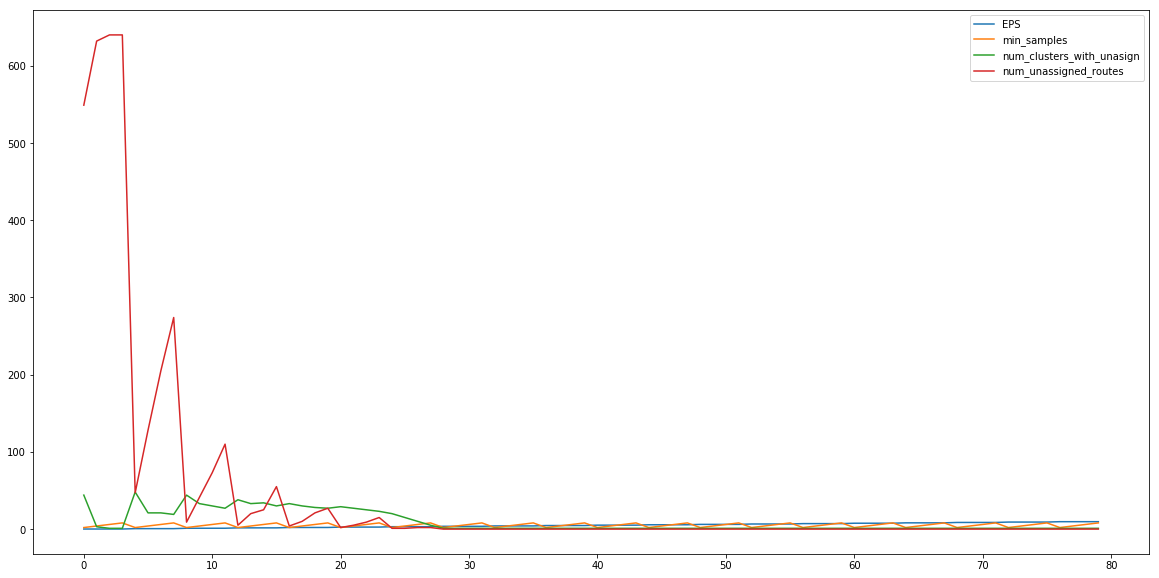

In [441]:
evaluation, maternal_model = evaluate_dbscan(input_df=maternal_data[variables], density=e_density, min_sample=e_min_sample, ideal=(3.1,6), prune=False)
plt.rcParams['figure.figsize'] = [20,10]
plt.plot(evaluation['EPS'], label='EPS')
plt.plot(evaluation['min_samples'], label='min_samples')
plt.plot(evaluation['num_clusters_with_unasign'], label='num_clusters_with_unasign')
plt.plot(evaluation['num_unassigned_districts'], label='num_unassigned_routes')
plt.legend()
plt.show()

In [442]:
maternal_data['class'] = maternal_model.labels_

In [443]:
variables = ['01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)',
 '01MaternalHealth: Maternal Case fatality rate (EmOC)',
 '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC',
 '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC']

In [444]:
maternal_data.columns

Index(['True', '01MaternalHealth: llFRYYZLkur',
       '01MaternalHealth: IVpv2Tj5rbj', '01MaternalHealth: UeBuoOKVSt9',
       '01MaternalHealth: DA4SHBTcotS', 'year', 'class'],
      dtype='object')

In [445]:
maternal_data.columns 

Index(['True', '01MaternalHealth: llFRYYZLkur',
       '01MaternalHealth: IVpv2Tj5rbj', '01MaternalHealth: UeBuoOKVSt9',
       '01MaternalHealth: DA4SHBTcotS', 'year', 'class'],
      dtype='object')

In [446]:
maternal_data.columns = ['True', '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)',
 '01MaternalHealth: Maternal Case fatality rate (EmOC)',
 '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC',
 '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC','year', 'Cluster']

In [448]:
maternal_data[variables + ['Cluster']].groupby('Cluster').mean().round(2).sort_values('01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)').to_csv('table_mean.csv')
maternal_data[variables + ['Cluster']].groupby('Cluster').std().round(2).sort_values('01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)').to_csv('table_stdev.csv')
maternal_data[variables + ['Cluster']].groupby('Cluster').min().round(2).sort_values('01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)').to_csv('table_min.csv')
maternal_data[variables + ['Cluster']].groupby('Cluster').max().round(2).sort_values('01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)').to_csv('table_max.csv')

[2009]


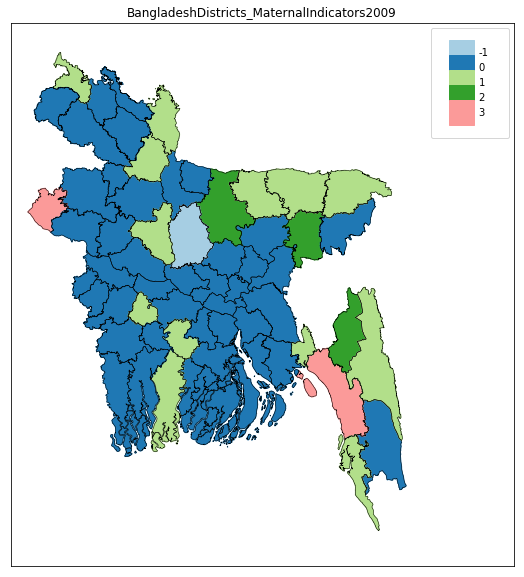

[2010]


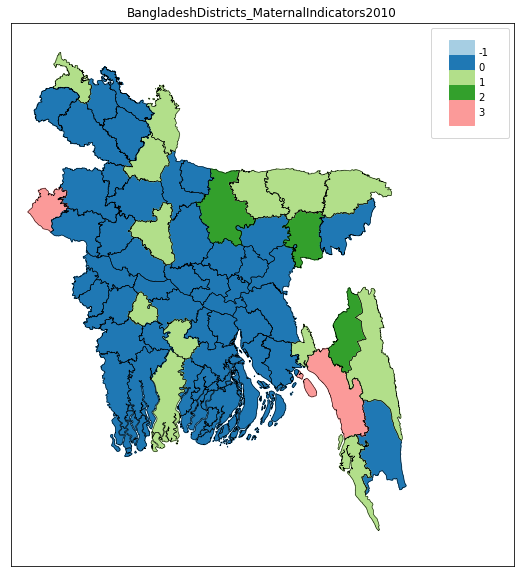

[2011]


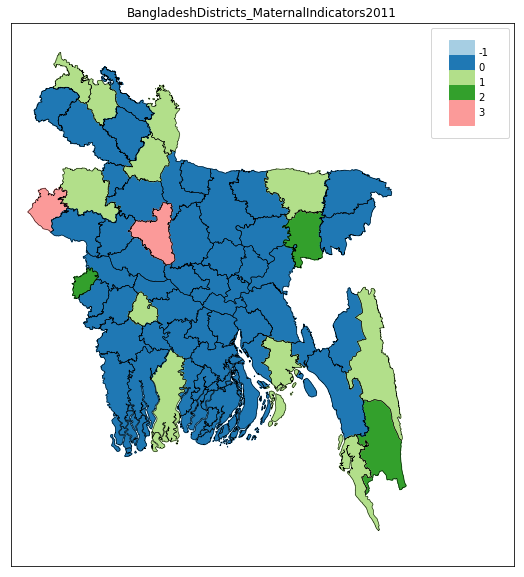

[2012]


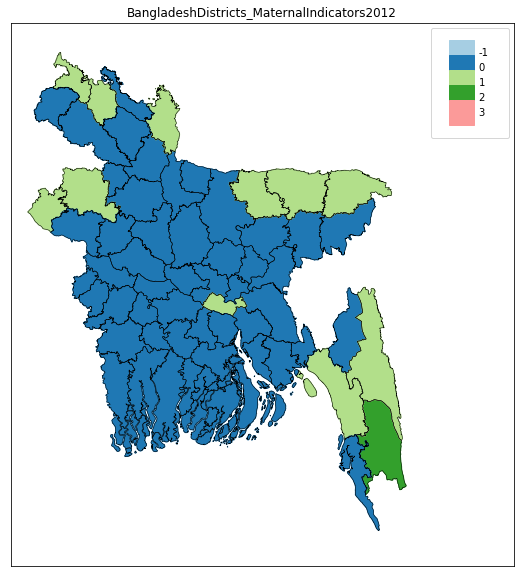

[2013]


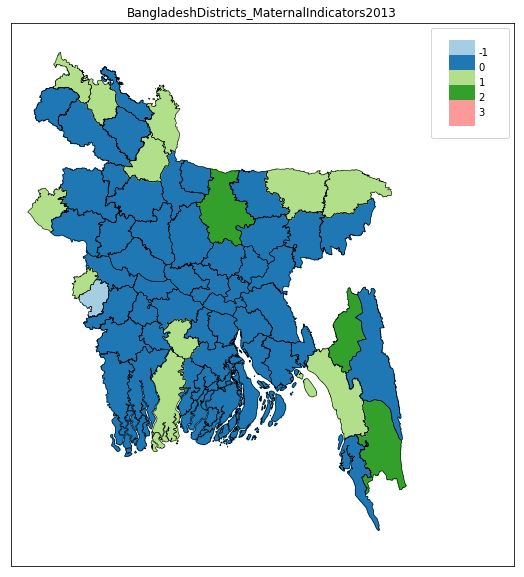

[2014]


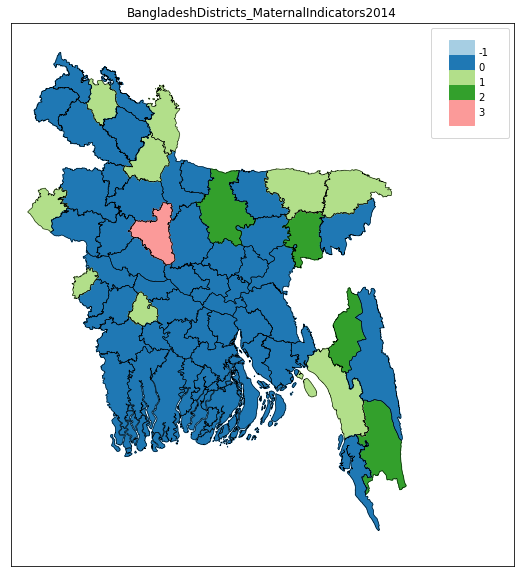

[2015]


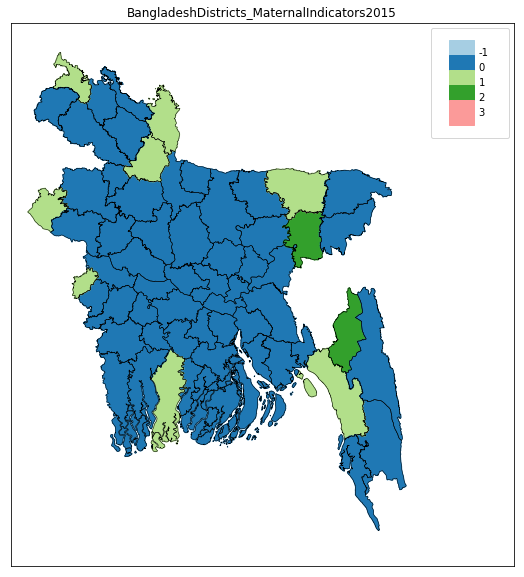

[2016]


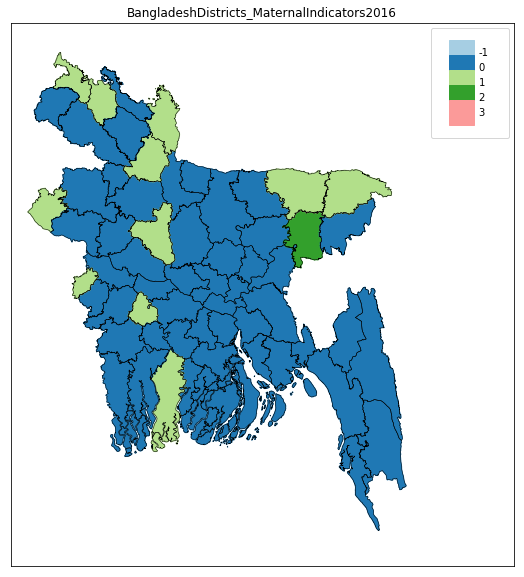

[2017]


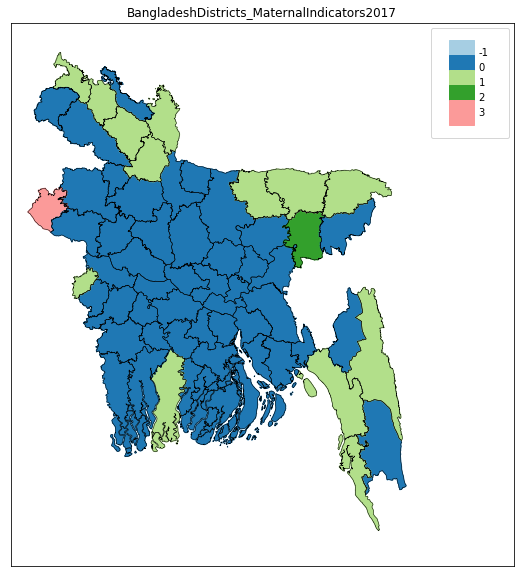

[2018]


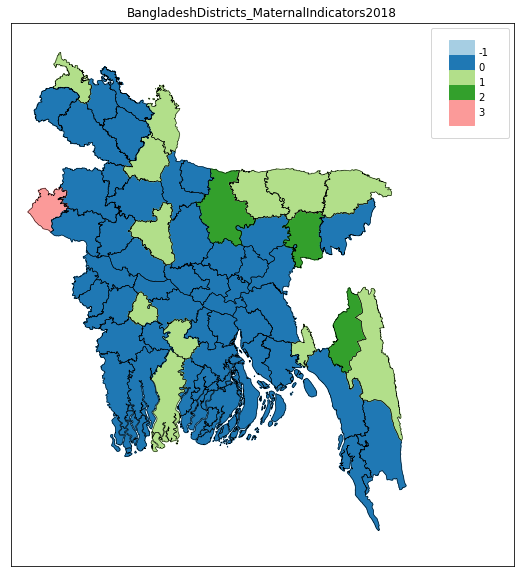

In [355]:
maternal_data, labs_cols = colors2clusters(maternal_data, cluster_var='class')
maternal_data.year = maternal_data.year.astype(int)
plt.rcParams['figure.figsize'] = [10,10]
for year in sorted(list(maternal_data['year'].unique())):
    m = create_mapobject(shp_path=SHAPE_PATH,shp_name=GEO_LEVEL)
    tmp = maternal_data[maternal_data['year'] == year]
    print(tmp['year'].unique())
    m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='True')
    plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title='BangladeshDistricts_MaternalIndicators' + str(year))

In [357]:
!convert -delay 100 -loop 0 BangladeshDistricts_MaternalIndicators2009.jpeg BangladeshDistricts_MaternalIndicators2010.jpeg BangladeshDistricts_MaternalIndicators2011.jpeg BangladeshDistricts_MaternalIndicators2012.jpeg BangladeshDistricts_MaternalIndicators2013.jpeg BangladeshDistricts_MaternalIndicators2014.jpeg BangladeshDistricts_MaternalIndicators2015.jpeg BangladeshDistricts_MaternalIndicators2016.jpeg BangladeshDistricts_MaternalIndicators2017.jpeg BangladeshDistricts_MaternalIndicators2018.jpeg BangladeshDistricts_MaternalIndicators.gif